In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

In [5]:
# Load the weekly Treasury panel
panel = pd.read_excel('data/treasury_panel_weekly.xlsx', sheet_name='panel')
panel['quote date'] = pd.to_datetime(panel['quote date'])

print(f"Panel shape: {panel.shape}")
print(f"Date range: {panel['quote date'].min().date()} to {panel['quote date'].max().date()}")
print(f"Number of weeks: {panel['quote date'].nunique()}")
print(f"\nBonds per week: {panel.groupby('quote date').size().mean():.0f} (avg)")

Panel shape: (156251, 16)
Date range: 2018-01-05 to 2025-12-31
Number of weeks: 418

Bonds per week: 374 (avg)


In [6]:
# Filter to nominal securities (exclude TIPS)
def filter_nominal(df):
    """Filter to nominal Treasuries suitable for curve fitting."""
    data = df.copy()
    data = data[~data['type'].str.contains('TIPS', case=False, na=False)].copy()
    data = data[(data['ytm'] > 0) & (data['ttm'] > 0.25) & (data['ttm'] <= 30)].copy()
    return data

panel_nominal = filter_nominal(panel)
print(f"Nominal securities: {len(panel_nominal):,} records")
print(f"Security types: {panel_nominal['type'].value_counts().to_dict()}")

Nominal securities: 140,946 records
Security types: {'note': 95119, 'bond': 35571, 'bill': 10256}


In [7]:
# Select a sample date for initial exploration
sample_date = panel_nominal['quote date'].max()
quotes = panel_nominal[panel_nominal['quote date'] == sample_date].copy()

print(f"Sample date: {sample_date.date()}")
print(f"Number of bonds: {len(quotes)}")
print(f"Maturity range: {quotes['ttm'].min():.2f} to {quotes['ttm'].max():.2f} years")
quotes[['type', 'ttm', 'cpn rate', 'ytm', 'price']].head(10)

Sample date: 2025-12-31
Number of bonds: 362
Maturity range: 0.25 to 29.87 years


,type,ttm,cpn rate,ytm,price
155889,bill,0.251882,0.000,0.035693,99.112854
155890,bill,0.265572,0.000,0.035336,99.074094
155891,bill,0.271047,0.000,0.035787,99.043185
155892,bill,0.284736,0.000,0.035474,99.003785
155893,note,0.287474,3.750,0.035575,100.054229
155894,bill,0.290212,0.000,0.035502,98.983927
155895,bill,0.303901,0.000,0.035558,98.934589
155896,bill,0.309377,0.000,0.035577,98.914926
155897,bill,0.323066,0.000,0.035548,98.868107
155898,note,0.328542,2.375,0.035188,99.634296


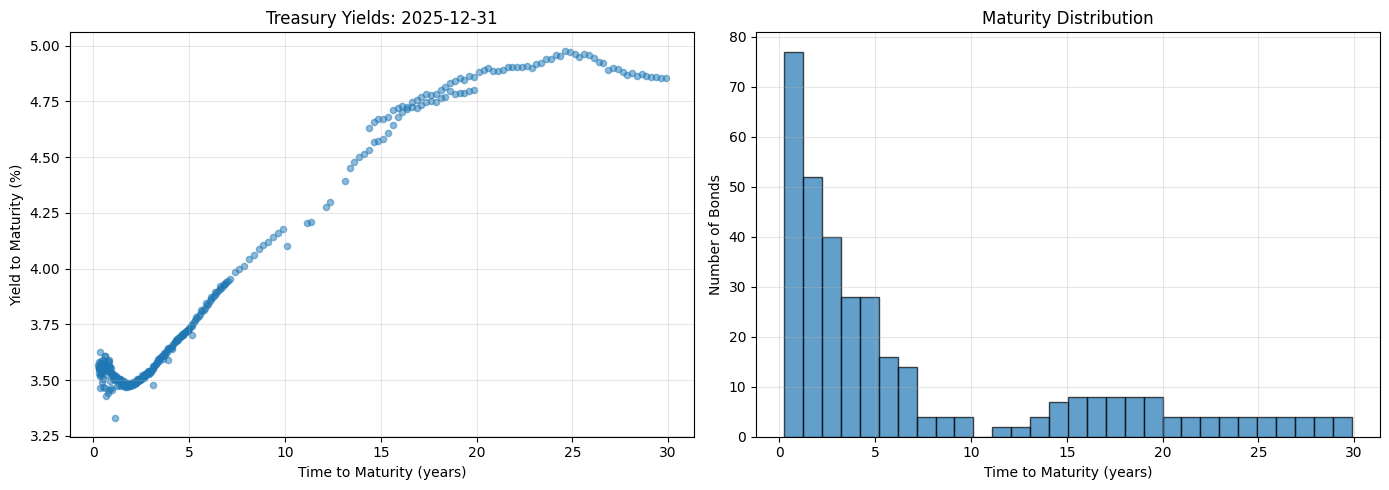

In [8]:
# Plot yields by maturity for sample date
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Yield vs maturity
axes[0].scatter(quotes['ttm'], quotes['ytm'] * 100, alpha=0.5, s=20)
axes[0].set_xlabel('Time to Maturity (years)')
axes[0].set_ylabel('Yield to Maturity (%)')
axes[0].set_title(f'Treasury Yields: {sample_date.date()}')
axes[0].grid(True, alpha=0.3)

# Distribution of maturities
axes[1].hist(quotes['ttm'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Time to Maturity (years)')
axes[1].set_ylabel('Number of Bonds')
axes[1].set_title('Maturity Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

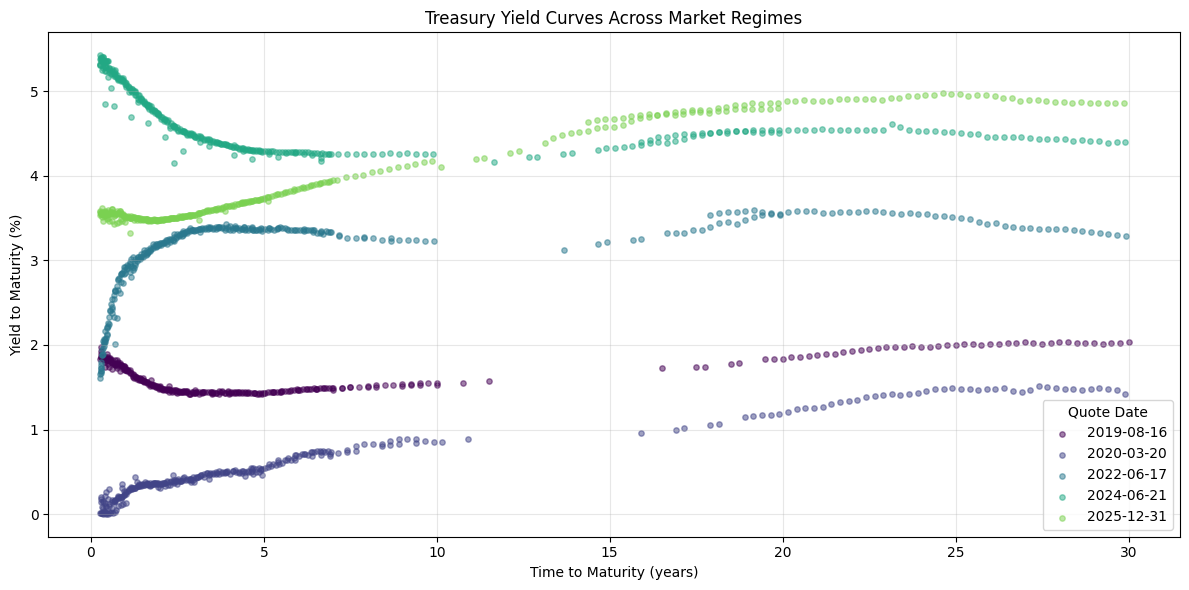

In [9]:
# Visualize yield curves across different regimes
# Show: pre-COVID, COVID trough, hiking cycle, recent
sample_dates_target = ['2019-08-15', '2020-03-20', '2022-06-15', '2024-06-15']
all_dates = panel_nominal['quote date'].drop_duplicates().sort_values()

# Add the most recent available date
latest_date = all_dates.max()
sample_dates_target.append(latest_date.strftime('%Y-%m-%d'))

fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(sample_dates_target)))

for i, target in enumerate(sample_dates_target):
    target_ts = pd.Timestamp(target)
    # Find nearest available date
    idx = all_dates.searchsorted(target_ts)
    if idx >= len(all_dates):
        idx = len(all_dates) - 1
    date = all_dates.iloc[idx]
    data = panel_nominal[panel_nominal['quote date'] == date]
    ax.scatter(data['ttm'], data['ytm'] * 100, 
               alpha=0.5, s=15, c=[colors[i]], label=date.strftime('%Y-%m-%d'))

ax.set_xlabel('Time to Maturity (years)')
ax.set_ylabel('Yield to Maturity (%)')
ax.set_title('Treasury Yield Curves Across Market Regimes')
ax.legend(title='Quote Date')
ax.grid(True, alpha=0.3)
plt.tight_layout()

In [ ]:
def nelson_siegel_yield(tau, beta0, beta1, beta2, lam):
    """Compute Nelson-Siegel yield at maturity tau."""
    tau = np.asarray(tau)
    tau_scaled = tau / lam
    tau_scaled = np.maximum(tau_scaled, 1e-6)  # Avoid division by zero
    
    exp_term = np.exp(-tau_scaled)
    L1 = (1 - exp_term) / tau_scaled
    L2 = L1 - exp_term
    
    return beta0 + beta1 * L1 + beta2 * L2


# Visualize factor loadings
tau_grid = np.linspace(0.25, 30, 100)
lam = 2.0
tau_scaled = tau_grid / lam
exp_term = np.exp(-tau_scaled)
L0 = np.ones_like(tau_grid)
L1 = (1 - exp_term) / tau_scaled
L2 = L1 - exp_term

plt.figure(figsize=(10, 5))
plt.plot(tau_grid, L0, label=r'$L_0$ (Level)', linewidth=2)
plt.plot(tau_grid, L1, label=r'$L_1$ (Slope)', linewidth=2)
plt.plot(tau_grid, L2, label=r'$L_2$ (Curvature)', linewidth=2)
plt.xlabel('Maturity (years)')
plt.ylabel('Loading')
plt.title(r'Nelson-Siegel Factor Loadings ($\lambda = 2$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()